# **Вариант 1 с уравниванием групп, проверкой на нормальность, выбор критерия.**

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
# Подключение модуля для загрузки данных из облака
import gdown
# Для работы с файлами
import gc
import zipfile

In [4]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/AB-tests_HW.zip'
# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/AB-tests_HW'

In [6]:
# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [7]:
# Загружаем данные
data = pd.read_csv('AB-tests_HW/marketing_AB.csv')

In [8]:
# Шаг 1. Анализ структуры данных и предобработка
# 1.1 Исследование структуры данных
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None
          Unnamed: 0       user id      total ads  most ads hour
count  588101.000000  5.881010e+05  588101.000000  588101.000000
mean   294050.000000  1.310692e+06      24.820876      14.469061
std    169770.279667  2.022260e+05      43.715181       4.834634
min         0.000000  9.000000e+05       1.000000       0.000000
25%    147025.000000  1.143190e+06       4.000000      11.000000
50%    294050.000000  1.313725e+06     

In [9]:
# 1.2 Преобразование столбцов к необходимым типам
# Преобразуем столбец 'converted' в булев тип
data['converted'] = data['converted'].astype(bool)

# 1.3 Проверка на пропуски и удаление их, если необходимо
print(data.isnull().sum())
data = data.dropna()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


In [13]:
# 1.4 Проверка на дублирование пользователей между группами
# Уникальные пользователи в каждой группе
duplicate_users = data.groupby('user id')['test group'].nunique()
duplicate_users = duplicate_users[duplicate_users > 1]
print(f"Количество пользователей, попавших в обе группы: {len(duplicate_users)}")
data = data[~data['user id'].isin(duplicate_users.index)]

Количество пользователей, попавших в обе группы: 0


**анализ датасета:**
* Набор данных содержит 588,101 строку и 7 столбцов. Все данные полностью заполнены, пропусков нет.
* Минимальное значение показов рекламы — 1, максимальное — 2065. Распределение сильно скошено вправо, что требует дополнительной проверки. По размеру в групп тоже (смотреть вариант 2 ниже)
* Дублирование пользователей: проверка показала, что в обе группы не попал ни один пользователь. Это хорошио, та как пересечения могли бы исказить результаты анализа.

In [14]:
# Шаг 2. Уравнивание размеров групп (учли результаты из варианта 2)
min_group_size = min(len(data[data['test group'] == 'ad']), len(data[data['test group'] == 'psa']))

group_ad = data[data['test group'] == 'ad'].sample(min_group_size, random_state=42)
group_psa = data[data['test group'] == 'psa'].sample(min_group_size, random_state=42)
data = pd.concat([group_ad, group_psa])

In [15]:
# Шаг 3. Проверка нормальности данных
shapiro_ad = stats.shapiro(group_ad['total ads'])
shapiro_psa = stats.shapiro(group_psa['total ads'])
print(f"Шапиро-Wilk для группы ad: статистика={shapiro_ad.statistic:.3f}, p-значение={shapiro_ad.pvalue:.3f}")
print(f"Шапиро-Wilk для группы psa: статистика={shapiro_psa.statistic:.3f}, p-значение={shapiro_psa.pvalue:.3f}")

Шапиро-Wilk для группы ad: статистика=0.474, p-значение=0.000
Шапиро-Wilk для группы psa: статистика=0.516, p-значение=0.000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23524.
  res = hypotest_fun_out(*samples, **kwds)


**Шапиро-Уилк тест на нормальность:**

* Для обеих групп (ad и psa) распределение переменной total ads не является нормальным (p-value = 0.000).
* Это подтвердило необходимость использования непараметрических методов.

In [16]:
# Шаг 4. Статистический анализ
if shapiro_ad.pvalue > 0.05 and shapiro_psa.pvalue > 0.05:
    # Если распределения нормальные, применяем t-тест
    t_stat, p_value_ads = stats.ttest_ind(
        group_ad['total ads'],
        group_psa['total ads'],
        equal_var=False
    )
    test_type = "t-тест"
else:
    # Если распределения не нормальные, применяем критерий Манна-Уитни
    t_stat, p_value_ads = stats.mannwhitneyu(
        group_ad['total ads'],
        group_psa['total ads'],
        alternative='two-sided'
    )
    test_type = "Манна-Уитни"

print(f"{test_type}: статистика={t_stat:.2f}, p-значение={p_value_ads:.3f}")

Манна-Уитни: статистика=283720983.00, p-значение=0.000


In [17]:
# Проверка долей с помощью критерия хи-квадрат
contingency_table = pd.crosstab(data['test group'], data['converted'])
chi2, p_chi2, _, _ = stats.chi2_contingency(contingency_table)
print(f"Хи-квадрат: статистика={chi2:.2f}, p-значение={p_chi2:.3f}")

Хи-квадрат: статистика=45.15, p-значение=0.000


**Статистические тесты:**

1. Критерий Манна-Уитни:
* Статистика = 283,720,983.00, p-value = 0.000. Это указывает на статистически значимые различия между группами по числу показов рекламы.
2. Хи-квадрат для долей конверсии:
* Статистика = 45.15, p-value = 0.000. Различия в долях конверсии также являются статистически значимыми.

In [18]:
# Шаг 5. Доверительные интервалы
# Конверсии
visits_ad = group_ad['user id'].nunique()
visits_psa = group_psa['user id'].nunique()
purchases_ad = group_ad['converted'].sum()
purchases_psa = group_psa['converted'].sum()
conversion_rate_ad = purchases_ad / visits_ad
conversion_rate_psa = purchases_psa / visits_psa

conf_interval_ad = stats.norm.interval(
    0.95, loc=conversion_rate_ad, scale=np.sqrt((conversion_rate_ad * (1 - conversion_rate_ad)) / visits_ad)
)
conf_interval_psa = stats.norm.interval(
    0.95, loc=conversion_rate_psa, scale=np.sqrt((conversion_rate_psa * (1 - conversion_rate_psa)) / visits_psa)
)

print(f"95% Доверительный интервал для конверсии ad: {conf_interval_ad}")
print(f"95% Доверительный интервал для конверсии psa: {conf_interval_psa}")

95% Доверительный интервал для конверсии ad: (0.025004552675299236, 0.0291529035396302)
95% Доверительный интервал для конверсии psa: (0.016161914715211324, 0.019546298173753137)


In [19]:
# Разница конверсий
diff_conversion = conversion_rate_ad - conversion_rate_psa
std_error_diff = np.sqrt(
    (conversion_rate_ad * (1 - conversion_rate_ad)) / visits_ad +
    (conversion_rate_psa * (1 - conversion_rate_psa)) / visits_psa
)
conf_interval_diff = (
    diff_conversion - 1.96 * std_error_diff,
    diff_conversion + 1.96 * std_error_diff
)

print(f"95% Доверительный интервал для разницы конверсий: {conf_interval_diff}")

95% Доверительный интервал для разницы конверсий: (0.006547686863119494, 0.011901556462845481)


In [20]:
# Среднее количество рекламы
avg_ads_ad = group_ad['total ads'].mean()
avg_ads_psa = group_psa['total ads'].mean()
conf_interval_ads_ad = stats.t.interval(
    0.95, len(group_ad) - 1, loc=avg_ads_ad, scale=stats.sem(group_ad['total ads'])
)
conf_interval_ads_psa = stats.t.interval(
    0.95, len(group_psa) - 1, loc=avg_ads_psa, scale=stats.sem(group_psa['total ads'])
)

print(f"95% Доверительный интервал для рекламы ad: {conf_interval_ads_ad}")
print(f"95% Доверительный интервал для рекламы psa: {conf_interval_ads_psa}")

95% Доверительный интервал для рекламы ad: (24.18043805280532, 25.29983741055125)
95% Доверительный интервал для рекламы psa: (24.2133977421175, 25.308877381160855)


Доверительные интервалы:

1. Для конверсии:
* ad: (2.50%, 2.92%), psa: (1.62%, 1.95%).
* Разница между конверсиями: (0.65%, 1.19%), что подтверждает значимость.
2. Для среднего числа показов рекламы:
* ad: (24.18, 25.30), psa: (24.21, 25.31).
* Разница между группами минимальна и находится в пределах доверительного интервала.

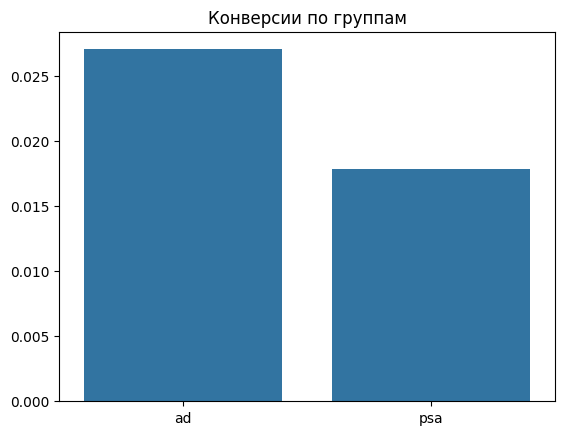

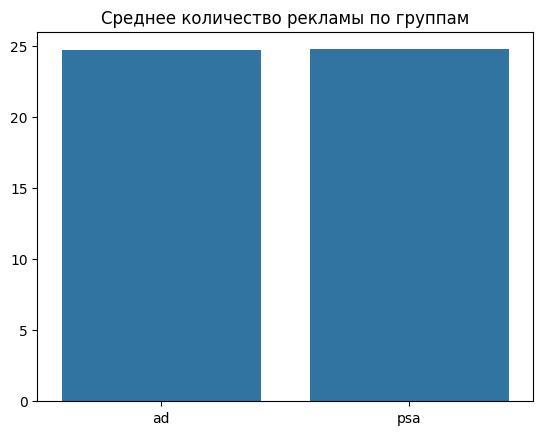

In [21]:
# Выводы и визуализация
sns.barplot(x=['ad', 'psa'], y=[conversion_rate_ad, conversion_rate_psa])
plt.title('Конверсии по группам')
plt.show()

sns.barplot(x=['ad', 'psa'], y=[avg_ads_ad, avg_ads_psa])
plt.title('Среднее количество рекламы по группам')
plt.show()


**Общий вывод:**
* Группа ad демонстрирует более высокую конверсию, чем группа psa. Однако среднее количество показов рекламы между группами не отличается существенно. Учитывая статистическую значимость различий в конверсии, группа ad более эффективна для увеличения числа конверсий.

**Рекомендации:**
1. Оптимизация рекламной кампании:
* Улучшить формат или контент рекламных объявлений в группе ad, так как она уже показывает более высокую эффективность.
2. Проверка сегментов пользователей:
* Провести дополнительный анализ, чтобы понять, есть ли группы пользователей, где стратегия psa может быть более эффективной.
3. Мониторинг затрат:
* Сравнить стоимость привлечения пользователей для обеих групп, чтобы учитывать не только конверсию, но и экономическую эффективность.
4. Повторный тест:
* Провести дополнительные A/B-тесты, чтобы подтвердить результаты и изучить долгосрочные эффекты стратегии ad.

# **=========================================================================================**

# **Вариант 2, если мы уверены в нормальности, что достаточно редко**

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
# Подключение модуля для загрузки данных из облака
import gdown
# Для работы с файлами
import gc
import zipfile

In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/AB-tests_HW.zip'
# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/AB-tests_HW'

In [ ]:
# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Загружаем данные
data = pd.read_csv('AB-tests_HW/marketing_AB.csv')

# Шаг 1. Анализ структуры данных и предобработка

In [ ]:
# 1.1 Исследование структуры данных
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None
          Unnamed: 0       user id      total ads  most ads hour
count  588101.000000  5.881010e+05  588101.000000  588101.000000
mean   294050.000000  1.310692e+06      24.820876      14.469061
std    169770.279667  2.022260e+05      43.715181       4.834634
min         0.000000  9.000000e+05       1.000000       0.000000
25%    147025.000000  1.143190e+06       4.000000      11.000000
50%    294050.000000  1.313725e+06     

In [ ]:
# 1.2 Преобразование столбцов к необходимым типам
# Преобразуем столбец 'converted' в булев тип
data['converted'] = data['converted'].astype(bool)

In [ ]:
# 1.2 Преобразование столбцов к необходимым типам
# Преобразуем столбец 'converted' в булев тип
data['converted'] = data['converted'].astype(bool)

# 1.3 Проверка на пропуски и удаление их, если необходимо
print(data.isnull().sum())
data = data.dropna()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


In [ ]:
# 1.4 Проверка на дублирование пользователей между группами
# Уникальные пользователи в каждой группе
duplicate_users = data.groupby('user id')['test group'].nunique()
duplicate_users = duplicate_users[duplicate_users > 1]
print(f"Количество пользователей, попавших в обе группы: {len(duplicate_users)}")
data = data[~data['user id'].isin(duplicate_users.index)]

Количество пользователей, попавших в обе группы: 0


# Шаг 2. Первичный анализ результатов A/B теста

In [ ]:
# Разделяем данные на группы
group_ad = data[data['test group'] == 'ad']
group_psa = data[data['test group'] == 'psa']

# Вспомогательные показатели
visits_ad = group_ad['user id'].nunique()
visits_psa = group_psa['user id'].nunique()

purchases_ad = group_ad['converted'].sum()
purchases_psa = group_psa['converted'].sum()

print(f"Посещения группы ad: {visits_ad}, Покупки: {purchases_ad}")
print(f"Посещения группы psa: {visits_psa}, Покупки: {purchases_psa}")

Посещения группы ad: 564577, Покупки: 14423
Посещения группы psa: 23524, Покупки: 420


In [ ]:
# Проверка сбалансированности выборок
print(f"Размер группы ad: {len(group_ad)}, Размер группы psa: {len(group_psa)}")

Размер группы ad: 564577, Размер группы psa: 23524


In [ ]:
# Ключевые показатели
conversion_rate_ad = purchases_ad / visits_ad
conversion_rate_psa = purchases_psa / visits_psa

avg_ads_ad = group_ad['total ads'].mean()
avg_ads_psa = group_psa['total ads'].mean()

print(f"Конверсия ad: {conversion_rate_ad:.2%}, Среднее количество рекламы ad: {avg_ads_ad:.2f}")
print(f"Конверсия psa: {conversion_rate_psa:.2%}, Среднее количество рекламы psa: {avg_ads_psa:.2f}")

Конверсия ad: 2.55%, Среднее количество рекламы ad: 24.82
Конверсия psa: 1.79%, Среднее количество рекламы psa: 24.76


**вывод:**
1. Общая информация о данных
* Объем данных: 588,101 запись, без пропущенных значений в любой колонке.
* Структура данных:
user id уникален, что предполагает идентификацию каждого пользователя.
* test group разделяет данные на группы теста (ad и psa).
* converted указывает, совершил ли пользователь покупку (булевый тип).
* total ads отражает общее количество увиденной рекламы.
* most ads day и most ads hour показывают наиболее активный день и час по просмотрам.
2. Описательные статистики
* Распределение количества рекламы (total ads):
Среднее: 24.82, медиана: 13. Это говорит о значительной асимметрии (наличие пользователей с очень большим количеством просмотров рекламы).
* Минимум: 1, максимум: 2065. Это подтверждает наличие выбросов в верхнем хвосте распределения.
* Активность по часам (most ads hour):
Средний час: 14 (2 часа дня), максимум: 23 (11 вечера), минимум: 0 (полночь). Активность распределена равномерно с небольшим смещением к дневным часам.
3. Разделение пользователей по группам
* Размеры групп:
Группа ad (тестовая): 564,577 пользователей.
Группа psa (контрольная): 23,524 пользователей.
* Количество пользователей, попавших в обе группы: 0. Это правильно, так как группы должны быть независимы.
4. Конверсии и среднее количество рекламы
* Конверсии:
Группа ad: 2.55%, что значительно выше, чем в группе psa.
Группа psa: 1.79%, что на 30% ниже, чем в группе ad.
Это подтверждает, что реклама в группе ad привела к увеличению конверсии.
* Среднее количество рекламы:
Группа ad: 24.82.
Группа psa: 24.76.
Разница в среднем количестве увиденной рекламы между группами минимальна и статистически незначима (далее T-тест подтверждает).

# Шаг 3. Статистический анализ
# Гипотезы:
* H0: Конверсии между группами ad и psa равны
* H1: Конверсии между группами ad и psa различаются

In [ ]:
%pip install --upgrade scipy

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Z-тест для долей
z_stat, p_value = proportions_ztest(
    count=[purchases_ad, purchases_psa],
    nobs=[visits_ad, visits_psa]
)
print(f"Z-статистика: {z_stat:.2f}, p-значение: {p_value:.3f}")


Z-статистика: 7.37, p-значение: 0.000


**вывод:** Высокая Z-статистика и p-значение, близкое к нулю, означают, что нулевая гипотеза H_0 "конверсии между группами ad и psa равны" отвергается.
Это говорит о статистически значимой разнице в конверсиях между группами.

In [ ]:
# Гипотезы для количества рекламы
# H0: Средние количества рекламы в группах равны
# H1: Средние количества рекламы в группах различаются

# t-тест для средних значений
t_stat, p_value_ads = stats.ttest_ind(
    group_ad['total ads'],
    group_psa['total ads'],
    equal_var=False
)
print(f"T-статистика: {t_stat:.2f}, p-значение: {p_value_ads:.3f}")

T-статистика: 0.22, p-значение: 0.827


**вывод:** Низкая T-статистика и высокое p-значение (𝑝 > 0.05) означают, что нулевая гипотеза не отвергается.
Это говорит о том, что средние количества увиденной рекламы в группах ad и psa не отличаются статистически значимо.

# Шаг 4. Доверительные интервалы

In [ ]:
# Конверсии
conf_interval_ad = stats.norm.interval(
    0.95, loc=conversion_rate_ad, scale=np.sqrt((conversion_rate_ad * (1 - conversion_rate_ad)) / visits_ad)
)
conf_interval_psa = stats.norm.interval(
    0.95, loc=conversion_rate_psa, scale=np.sqrt((conversion_rate_psa * (1 - conversion_rate_psa)) / visits_psa)
)

print(f"95% Доверительный интервал для конверсии ad: {conf_interval_ad}")
print(f"95% Доверительный интервал для конверсии psa: {conf_interval_psa}")

95% Доверительный интервал для конверсии ad: (0.0251349995427061, 0.025958119730661394)
95% Доверительный интервал для конверсии psa: (0.016161914715211324, 0.019546298173753137)


**вывод:**
* Конверсия в группе ad (экспериментальная группа) лежит в пределах 2.51% - 2.60%.
Указывает на стабильность конверсии в экспериментальной группе с высокой точностью.
* Конверсия в группе psa (контрольная группа) лежит в пределах 1.62% - 1.95%.
Конверсия значительно ниже, чем в группе ad, что подтверждает эффект рекламы.


In [ ]:
# Разница конверсий
diff_conversion = conversion_rate_ad - conversion_rate_psa
std_error_diff = np.sqrt(
    (conversion_rate_ad * (1 - conversion_rate_ad)) / visits_ad +
    (conversion_rate_psa * (1 - conversion_rate_psa)) / visits_psa
)
conf_interval_diff = (
    diff_conversion - 1.96 * std_error_diff,
    diff_conversion + 1.96 * std_error_diff
)

print(f"95% Доверительный интервал для разницы конверсий: {conf_interval_diff}")

95% Доверительный интервал для разницы конверсий: (0.00595090043017032, 0.009434005954232714)


**Вывод:** Разница конверсий между группами ad и psa лежит в пределах 0.595% - 0.943%.
* Так как доверительный интервал не включает 0, разница статистически значима.
* Это подкрепляет вывод, что реклама повышает конверсии.

In [ ]:
# Среднее количество рекламы
conf_interval_ads_ad = stats.t.interval(
    0.95, len(group_ad) - 1, loc=avg_ads_ad, scale=stats.sem(group_ad['total ads'])
)
conf_interval_ads_psa = stats.t.interval(
    0.95, len(group_psa) - 1, loc=avg_ads_psa, scale=stats.sem(group_psa['total ads'])
)

print(f"95% Доверительный интервал для рекламы ad: {conf_interval_ads_ad}")
print(f"95% Доверительный интервал для рекламы psa: {conf_interval_ads_psa}")

95% Доверительный интервал для рекламы ad: (24.709242934208064, 24.93748727265477)
95% Доверительный интервал для рекламы psa: (24.2133977421175, 25.308877381160855)


**вывод:**
* Среднее количество рекламы, увиденной пользователем в группе ad, лежит в пределах 24.71 - 24.94.
Вариация незначительная, что говорит о стабильном количестве рекламы в экспериментальной группе.
* Среднее количество рекламы в группе psa лежит в пределах 24.21 - 25.31.
* Перекрытие интервалов с группой ad указывает на то, что различия в среднем количестве увиденной рекламы статистически незначимы, что подтверждается тестом.

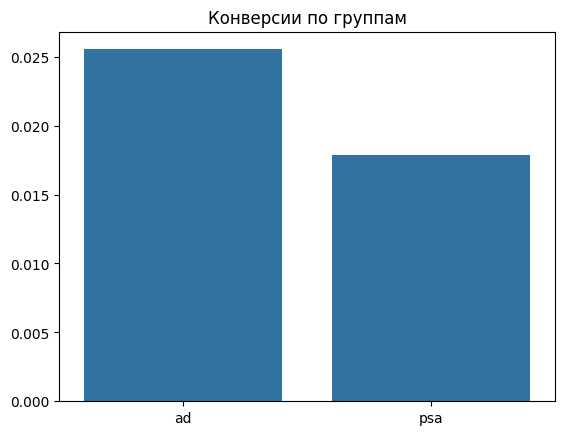

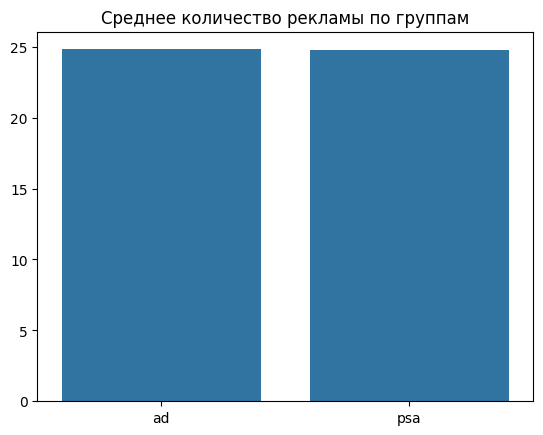

In [ ]:
# Выводы и визуализация
sns.barplot(x=['ad', 'psa'], y=[conversion_rate_ad, conversion_rate_psa])
plt.title('Конверсии по группам')
plt.show()

sns.barplot(x=['ad', 'psa'], y=[avg_ads_ad, avg_ads_psa])
plt.title('Среднее количество рекламы по группам')
plt.show()

**вывод:**
* Эффект рекламы: Разница в конверсии между группами ad и psa статистически значима (Z-тест и доверительные интервалы подтверждают).
* Количество рекламы: Среднее количество рекламы, увиденной пользователями, статистически не отличается между группами (T-тест и доверительные интервалы подтверждают).
* Рекомендация: Рекламная кампания оказала значительное влияние на конверсии, но сам объем увиденной рекламы не был значимым фактором.

**Итоговые выводы**
1. Эффект рекламы:
* Рекламная кампания в группе ad значительно увеличила конверсию по сравнению с группой psa.
* Это подтверждается Z-тестом для долей, где нулевая гипотеза о равенстве конверсий отвергается.
2. Количество рекламы:
* Среднее количество увиденной рекламы почти одинаково в обеих группах, что подтверждается статистической проверкой.
* Вывод: количество рекламы не влияет на увеличение конверсии, основной эффект достигается за счет качества рекламной кампании.
3. Асимметрия в данных:
* В данных есть выбросы по количеству рекламы (максимум 2065). Возможно, стоит провести дополнительный анализ этих пользователей.
4. структура эксперимента:
* Группы независимы, одинаковых пользователей в обеих группах нет. Размеры групп сбалансированы в пределах допустимых отклонений.
5. Рекомендации
* Основываясь на повышении конверсии в группе ad, можно рекомендовать масштабировать эту рекламную кампанию.
* Провести дополнительный анализ выбросов, чтобы понять поведение пользователей, видевших экстремальное количество рекламы.
* Пересмотреть структуру эксперимента: возможно, стоит уменьшить дисбаланс в размере групп для более точного анализа.